# Basic Artificial Neural Networks

In [1]:
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import matplotlib

%matplotlib inline

matplotlib.style.use('ggplot')

# Framework

In [2]:
%run assignment1_modules.ipynb

In [3]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    if state.get('old_grad'):
        flag = True
        old_dx = state['old_grad']
    else:
        flag = False
        old_dx = dx
    for cur_layer_x, cur_layer_dx, cur_layer_old_dx in zip(x,dx, old_dx): 
        for cur_x, cur_dx, cur_old_dx in zip(cur_layer_x,cur_layer_dx, cur_layer_old_dx):
            cur_old_grad = (config['momentum'] * cur_old_dx) if flag else 0 + config['learning_rate'] * cur_dx
            np.add(cur_x, -cur_old_grad, out=cur_x)
    old_dx = dx.copy()

In [4]:
def accuracy(A, B):
    return np.sum(np.argmax(A,axis=-1) == np.argmax(B, axis=-1)) * 1. / A.shape[0]

Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 0.005, 'momentum': 0.1}
optimizer_state = {}

# Looping param2
n_epoch = 30
batch_size = 128

In [6]:
# batch generator
def get_batches(X, Y, batch_size):
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

# Digit classification 

We are using [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. Lets start with [cool visualization](http://scs.ryerson.ca/~aharley/vis/). The most beautiful demo is the second one, if you are not familiar with convolutions you can return to it in several lectures. 

In [7]:
import os
from sklearn.datasets import fetch_mldata

# Fetch MNIST dataset and create a local copy.
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_mldata("mnist-original")
    X, y = mnist.data / 255.0, mnist.target
    np.savez('mnist.npz', X=X, y=y)

    
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = np.array(enc.fit_transform(y.reshape(-1, 1)).todense())

perm = np.random.permutation(X.shape[0])
X = X[perm]
y = y[perm]

X_train, y_train = X[0:50000], y[0:50000]
X_val, y_val = X[50000:60000], y[50000:60000]
X_test, y_test = X[60000:], y[60000:]
    
print('Training', X_train.shape, y_train.shape)
print('Validation', X_val.shape, y_val.shape)
print('Test', X_test.shape, y_test.shape)

Training (50000, 784) (50000, 10)
Validation (10000, 784) (10000, 10)
Test (10000, 784) (10000, 10)


- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchMeanSubtraction` between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchMeanSubtraction` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Hint: logloss for MNIST should be around 0.5. 

In [31]:
def trainNetwork(net, epoch, loss_history):
    net.train()
    for i in range(epoch):
        for x_batch, y_batch in get_batches(X_train, y_train, batch_size):
            net.zeroGradParameters()
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)      
        loss_history.append(loss)
        print('Epoch: %d ' %(i))
        print("  train accuracy:\t\t{:.2f} %".format(accuracy(net.forward(X_train), y_train)*100))
        print("  validation accuracy:\t\t{:.2f} %".format(accuracy(net.forward(X_val), y_val)*100))

    net.evaluate()    
    

    #     acc = accuracy(net.forward(X), one_hot_y)


In [32]:
criterion = ClassNLLCriterion()
net1 = Sequential()
net1.add(Linear(784,100))
net1.add(LeakyReLU())
net1.add(Linear(100,50))
net1.add(LeakyReLU())
net1.add(Linear(50,10))
net1.add(SoftMax())
print(net1)

Linear 784 -> 100
LeakyReLU
Linear 100 -> 50
LeakyReLU
Linear 50 -> 10
SoftMax



In [33]:
net2 = Sequential()
net2.add(Linear(784,100))
net2.add(BatchMeanSubtraction(1))
net2.add(LeakyReLU())
net2.add(Linear(100,50))
net2.add(BatchMeanSubtraction(1))
net2.add(LeakyReLU())
net2.add(Linear(50,10))
net2.add(SoftMax())
print(net2)

Linear 784 -> 100
BatchMeanNormalization
LeakyReLU
Linear 100 -> 50
BatchMeanNormalization
LeakyReLU
Linear 50 -> 10
SoftMax



In [34]:
loss_history1 = []
loss_history2 = []

In [35]:
# Iptimizer params
optimizer_config = {'learning_rate' : 0.0005, 'momentum': 0.9}
optimizer_state = {}

# Looping param2
n_epoch = 5
batch_size = 1025

In [36]:
trainNetwork(net1, n_epoch, loss_history1)
trainNetwork(net2, n_epoch, loss_history2)

Epoch: 0 
  train accuracy:		84.78 %
  validation accuracy:		84.45 %
Epoch: 1 
  train accuracy:		91.04 %
  validation accuracy:		90.47 %
Epoch: 2 
  train accuracy:		92.57 %
  validation accuracy:		92.19 %
Epoch: 3 
  train accuracy:		93.96 %
  validation accuracy:		93.39 %
Epoch: 4 
  train accuracy:		94.95 %
  validation accuracy:		94.34 %
Epoch: 0 
  train accuracy:		84.83 %
  validation accuracy:		84.52 %
Epoch: 1 
  train accuracy:		90.82 %
  validation accuracy:		90.44 %
Epoch: 2 
  train accuracy:		92.72 %
  validation accuracy:		92.10 %
Epoch: 3 
  train accuracy:		93.93 %
  validation accuracy:		93.54 %
Epoch: 4 
  train accuracy:		94.79 %
  validation accuracy:		94.05 %


In [37]:
net = net1
print("  test accuracy:\t\t{:.2f} %".format(accuracy(net.forward(X_test), y_test)*100))

  test accuracy:		94.81 %


In [38]:
net = net2
print("  test accuracy:\t\t{:.2f} %".format(accuracy(net.forward(X_test), y_test)*100))

  test accuracy:		94.49 %


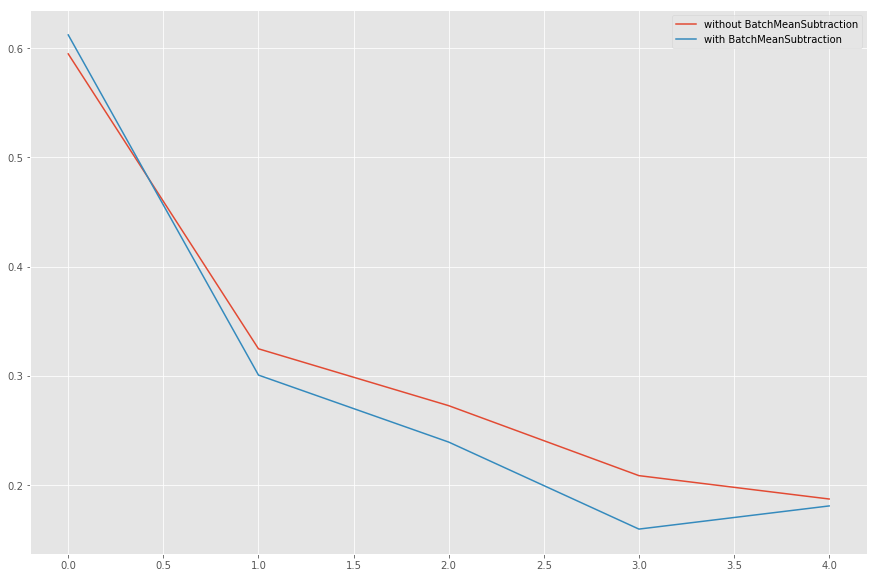

In [39]:
plt.clf()
plt.figure(figsize=(15,10))
plt.plot(loss_history1[:100],label='without BatchMeanSubtraction')
plt.plot(loss_history2[:100],label='with BatchMeanSubtraction')
plt.legend()
plt.show()

Write your personal opinion on the activation functions, think about computation times too. Does `BatchMeanSubtraction` help?

**Finally**, use all your knowledge to build a super cool model on this dataset, do not forget to split dataset into train and validation. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. 

In [41]:
criterion = ClassNLLCriterion()
cool_network  = Sequential()
cool_network.add(Linear(784, 1000))
cool_network.add(Dropout(0.6))
cool_network.add(ReLU())
cool_network.add(Linear(1000, 50))
cool_network.add(ReLU())
cool_network.add(Linear(50,10))
cool_network.add(SoftMax())
print(cool_network)

Linear 784 -> 1000
Dropout
ReLU
Linear 1000 -> 50
ReLU
Linear 50 -> 10
SoftMax



In [42]:
# Iptimizer params
optimizer_config = {'learning_rate' : 0.005, 'momentum': 0.9}
optimizer_state = {}

# Looping param2
n_epoch = 50
batch_size = 101

In [43]:
trainNetwork(cool_network, n_epoch, [])
net = cool_network

Epoch: 0 
  train accuracy:		91.37 %
  validation accuracy:		92.22 %
Epoch: 1 
  train accuracy:		94.33 %
  validation accuracy:		94.66 %
Epoch: 2 
  train accuracy:		95.55 %
  validation accuracy:		94.34 %
Epoch: 3 
  train accuracy:		96.34 %
  validation accuracy:		95.56 %
Epoch: 4 
  train accuracy:		96.94 %
  validation accuracy:		96.01 %
Epoch: 5 
  train accuracy:		97.50 %
  validation accuracy:		96.52 %
Epoch: 6 
  train accuracy:		97.24 %
  validation accuracy:		96.51 %


KeyboardInterrupt: 

Print here your accuracy. It should be around 90%.

In [44]:
cool_network.evaluate()
print("  test accuracy:\t\t{:.2f} %".format(accuracy(cool_network.forward(X_test), y_test)*100))

  test accuracy:		96.84 %
